In [0]:
!nvcc --version


In [0]:
!pip install bert-embedding
!pip install mxnet-cu100

In [0]:
import mxnet as mx
from bert_embedding import BertEmbedding

ctx = mx.gpu(0)
bert = BertEmbedding(ctx=ctx)

Vocab file is not found. Downloading.


In [0]:
import pandas as pd

positive = pd.read_csv('positive_sentences.csv',header= None)
check_me = positive[positive[1].__eq__("001.tei.xml")]
sentences_list = list()
for row in check_me.iterrows():
  sentences_list.append(row[1][0])
  
check_me

In [0]:
bert = BertEmbedding(ctx=ctx,max_seq_length=150)


In [0]:
results = bert(sentences_list)

In [0]:
import numpy as np
for result in results:
  print(len(result[0]),np.average(np.array(result[1]),axis = 0).shape)
#print(np.average(np.array(results[0][1]),axis = 0).shape)
#print(results[0][0])

20 (768,)
103 (768,)
8 (768,)
10 (768,)
7 (768,)
12 (768,)
45 (768,)
24 (768,)
20 (768,)
13 (768,)
14 (768,)
118 (768,)
25 (768,)
28 (768,)
81 (768,)


In [0]:
import zipfile
with zipfile.ZipFile("train_papers.zip","r") as zip_ref:
    zip_ref.extractall('train_papers')

In [0]:
import os 
from numpy import dot
from numpy.linalg import norm
import numpy as np

papers = os.listdir("train_papers")
dataset = pd.read_csv("sentences111.csv")
#print(dataset)
i = 1
cosine = dict()#list()
cosine1 = dict()
papers.sort()
for paper in papers:
  
  print(paper)
  positive_sentences =  positive[positive[1].__eq__(paper)]
  sentences = dataset[dataset['paper'].__eq__(paper)]
  
  positive_sentences_list = list()
  for row in positive_sentences.iterrows():
    positive_sentences_list.append(str(row[1][0]))
  
  positive_results = bert(positive_sentences_list)
  positive_bert = list()
  for result in positive_results:
    positive_bert.append(np.average(np.array(result[1]),axis = 0))
  
  
  
  #print(len(positive_sentences_list))
  sentences_list = list()
  for row in sentences.iterrows():
    sen = row[1][0]
    if sen in positive_sentences_list:
      #print(i)
      i += 1
    sentences_list.append(str(row[1][0]))
  
  sentences_results = bert(sentences_list)
  #sentences_bert = list()
  for result in sentences_results:
    sent = result[0]
    sentence = ""
    for word in sent:
      sentence += word+" "
    
    sentences_bert = np.average(np.array(result[1]),axis = 0)
    max_cosine = 0.0
    for emb in positive_bert:
      cos_sim = dot(sentences_bert, emb)/(norm(sentences_bert)*norm(emb))
      if max_cosine < cos_sim:
        max_cosine = cos_sim
   
  
    if sentence[:-1] in sentences_list:
      cosine[sentence[:-1]] = max_cosine
    elif sentence in sentences_list:
      cosine[sentence] = max_cosine
    #cosine.append(max_cosine)

    

In [0]:
i = 0
cosine_sim = list()
for j in cosine.values():
  if j > 0.82:
    i += 1
  cosine_sim.append(j)
  
print(i)

4915


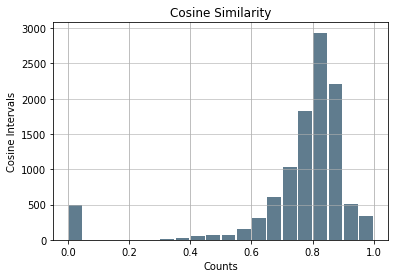

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
my_hist = pd.Series(cosine_sim)
my_hist.plot.hist(grid=True, bins=20, rwidth=0.9,
                   color='#607c8e')
plt.title('Cosine Similarity')
plt.xlabel('Counts')
plt.ylabel('Cosine Intervals')
plt.grid(axis='y', alpha=0.75)

In [0]:
labels = list()
for row in dataset.iterrows():
  sentence = row[1][0]
  if sentence not in cosine:
    labels.append(0)
  else:
    if cosine[sentence] > 0.82:
      labels.append(1)
    else:
      labels.append(0)

In [0]:
from collections import Counter

count = Counter(labels)
print(count)

Counter({0: 5735, 1: 4915})


In [0]:
new_dataset = dataset.iloc[:,:-1]
new_dataset['label'] = labels
print(new_dataset.shape)

(10650, 6)


In [0]:
new_dataset.to_csv("train_sentences1.csv",header=True,index=None)